Assignment 8: Open-Set Classification
=====================================


Microsoft Forms Document: https://forms.office.com/r/xY9sQDQdGh

We select the MNIST dataset and define several classes to be known, known unknown (used as negative class during training) and unknown unknown (not used for training at all).

Task 1: Target Vectors
----------------------

For our training dataset, we want to use four classes of MNIST digits (4,5,8,9) as known classes and four (0,2,3,7) as known unknowns. 
The remaining two classes shall be ignored during training and validation, amd only be used for testing purposes.

When we want to train with our adapted softmax function, we need to assign the correct target vectors for the classes. 
These are $(1,0,0,0)$, $(0,1,0,0)$, $(0,0,1,0)$ and $(0,0,0,1)$ for the known classes, respectively. 
For known unknown classes, the target vector is $\left(\frac14,\frac14,\frac14,\frac14\right)$, throughout.


In [ ]:
import torch
import torchvision

# define the three types of classes
known_classes = (4,5,8,9)
known_unknown_classes = (0,2,3,7)
unknown_classes = (1,6)
O = len(known_classes)

def target_vector(index):
  one_hot = torch.zeros(O)
  same = torch.tensor([1/O]*O)
  # select correct one-hot vector for known classes, and the 1/O-vectors for unknown classes
  for i, c in enumerate(known_classes):
    if index == c:
      one_hot[i] = 1
      return one_hot
  return same

Test 1: Check your Target Vectors
---------------------------------

Test that your target vectors are correct, for all tpyes of known and unknown samples.

In [ ]:
# check that the target vectors for known classes are correct
for index in known_classes:
  t = target_vector(index)
  assert sum(t) == 1
  assert max(t) == 1
  assert t.shape == (4,)
  print(index, t)

# check that the target vectors for unknown classes are correct
for index in known_unknown_classes + unknown_classes:
  t = target_vector(index)
  assert sum(t) == 1
  assert max(t) == 0.25
  assert t.shape == (4,)
  print(index, t)
  

4 tensor([1., 0., 0., 0.])
5 tensor([0., 1., 0., 0.])
8 tensor([0., 0., 1., 0.])
9 tensor([0., 0., 0., 1.])
0 tensor([0.2500, 0.2500, 0.2500, 0.2500])
2 tensor([0.2500, 0.2500, 0.2500, 0.2500])
3 tensor([0.2500, 0.2500, 0.2500, 0.2500])
7 tensor([0.2500, 0.2500, 0.2500, 0.2500])
1 tensor([0.2500, 0.2500, 0.2500, 0.2500])
6 tensor([0.2500, 0.2500, 0.2500, 0.2500])


Task 2 and 3: Training Dataset
------------------------
We rely on the MNIST dataset implementation from PyTorch and adapt some parts of it. 
Mainly, we will let PyTorch load the dataset by calling the base class constructor and modify the `self.data` and `self.targets` ourselves.
Additionally, we need to implement the index function to return the data and targets in the desired format.

Since Jupyter Notebook does not allow splitting classes over several code boxes, the two tasks are required to be solved in the same code box.

In [ ]:
class DataSet(torchvision.datasets.MNIST):
  def __init__(self, purpose="train"):
    # call base class constructor to handle the data loading
    super(DataSet, self).__init__(
      root = "./temp",
      train = purpose=="train",
      download=True,
      transform = torchvision.transforms.ToTensor()
    )
    # select the valid classes based on the current purpose
    if purpose == "train" or purpose == "valid":
      self.classes = known_classes + known_unknown_classes
    else:       ### purpose == "test"
      self.classes = known_classes + unknown_classes

    ####### ↓↓↓ 目前的 self.tagets 还没有被 one-hot 编码，是由 [0,9] 组成， 且 shape = (60000,)
    valid_sample_idx = [x in self.classes for x in self.targets] ### 相当于一层 mask, 把数据中 targets 属于 self.classes 的数据 idx 给抽出来了 [True, False ...]

    # sub-select the data of valid classes
    self.data = self.data[valid_sample_idx]
    # select the targets of valid classes
    self.targets = self.targets[valid_sample_idx]

  def __getitem__(self, index): ### get Item 到底干嘛用的？？？ 为什么要以 index 为参数？？？
    # perform appropriate actions on the data and the targets
    input, target = super().__getitem__(index)
    target = target_vector(target)

    return input, target

Test 2: Data Sets
-----------------

Instantiate the training dataset.
Implement a data loader for the training dataset with a batch size of 64.
Assure that all inputs are of the desired type and shape.
Assert that the target values are in the correct format, and the sum of the target values per sample is one.

In [ ]:
# instantiate the training dataset
train_set = DataSet(purpose="train")
train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=64, shuffle=True)

# assert that we have not filtered out all samples
assert len(train_loader) != 0

# check the batch and assert valid data and sizes
for x,t in train_loader:
  assert len(t) == len(x)
  assert t.shape[1] == 4
  assert torch.sum(t) == t.shape[0]
  assert len(x) <= 64
  assert torch.all(torch.sum(t, axis=1) == 1)
  assert x.shape == torch.Size([x.shape[0], 1, 28, 28])
  assert x.dtype == torch.float32
  assert torch.max(x) <= 1
  

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./temp/DataSet/raw/train-images-idx3-ubyte.gz to ./temp/DataSet/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./temp/DataSet/raw/train-labels-idx1-ubyte.gz to ./temp/DataSet/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./temp/DataSet/raw/t10k-images-idx3-ubyte.gz to ./temp/DataSet/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./temp/DataSet/raw/t10k-labels-idx1-ubyte.gz to ./temp/DataSet/raw



Task 4: Utility Function
------------------------

Implement a function that splits a batch of samples into known and unknown parts. For the known parts, also provide the target vectors.
How can we know which of the data samples are known smaples, and which are unknown?

实现一个函数，将一批样本分割成已知和未知的部分。对于已知部分，还要提供目标向量。我们怎样才能知道哪些数据样本是已知部分，哪些是未知部分？

In [ ]:
def split_known_unknown(batch, targets):
  # select the indexes at which known and unknown samples exist
  known = targets.max(dim=1)[0] == 1
  unknown = ~known
  # return the known samples, the targets of the known samples, as well as the unknown samples
  return batch[known], targets[known], batch[unknown]

Task 5: Loss Function Implementation
------------------------------------

We implement a loss function that implements an autograd function, i.e., we define both the forward and the backward pass for our loss computation.

<img src="https://s2.loli.net/2022/06/06/ZDFb3JUa8E4Rpsn.png" width="50%">

In [ ]:
class AdaptedSoftMax(torch.autograd.Function):

  # implement the forward propagation
  @staticmethod
  def forward(ctx, logits, targets):
    # compute the log probabilities via log_softmax
    log_y = torch.nn.functional.log_softmax(logits, dim=1)
    # save required values for backward pass
    ctx.save_for_backward(log_y, targets)
    # compute loss
    loss = - torch.sum(targets * log_y)
    return loss

  # implement Jacobian
  @staticmethod
  def backward(ctx, result):
    # get results stored from forward pass
    log_y, targets = ctx.saved_tensors
    # compute derivative of loss w.r.t. the logits
    dJ_dy = torch.exp(log_y) - targets
    # return the derivatives; none for derivative for the targets
    return dJ_dy, None

# DO NOT REMOVE!
# here we set the adapted softmax function to be used later
adapted_softmax = AdaptedSoftMax.apply

Task 5a: Alternative Loss Function
----------------------------------

If the implementation of the autograd function in Task 5 is too complicated, we can also rely on PyTorch to compute the gradient for us.
In this case, we only need to define the forward pass, i.e., the loss function itself.

如果任务5中autograd函数的实现过于复杂，我们也可以依靠PyTorch来为我们计算梯度。在这种情况下，我们只需要定义前向通道，即损失函数本身。

In [ ]:
def adapted_softmax_alt(logits, targets):   ### 这个是如何运用的？？？
  # compute cross-entropy loss on top of softmax values of the logits
  loss = - torch.sum(targets * torch.nn.functional.log_softmax(logits, dim=1))
  return loss

Task 6: Confidence Evaluation
-----------------------------

Implement a function to compute the confidence value for a given batch of samples. Make sure to split the batch between known and unknown samples, and compute the confidence value for both separately.

实现一个函数来计算一批给定样本的置信度。确保在已知和未知样本之间分割批次，并分别计算两者的置信度。

In [ ]:
def confidence(logits, targets):
  # comupte softmax confidences
  y = torch.nn.functional.softmax(logits,dim=1) ## y.shape = (N,O)
  # split between known and unknown
  known, known_targets, unknown = split_known_unknown(y, targets)
  # compute confidence score for known targets
  
  # conf_known = (known * known_targets).sum(dim=1)  
  conf_known = sum(known[known_targets.bool()]) ###### (known*known_targets).sum(dim=1)
  # compute confidence score for unknown targets
  conf_unknown = torch.sum(1 - unknown.max(dim=1)[0] + 1/O)   ### torch.max(向量，dim)[0] 代表取值？？
  return conf_known + conf_unknown ### 为什么要 相加 返回？

Test 3: Check Confidence Implementation
---------------------------------------

Test that your confidence implementation does what it is supposed to do.

In [ ]:
known_classes = (4,5,8,9)
known_unknown_classes = (0,2,3,7)
unknown_classes = (1,6)

# select good logit vectors for known and unknown classes
logits = torch.tensor([
  [10.,0.,0.,0.,],
  [-10.,0.,-10.,-10.],
  [0.,0.,0.,0.]
])
# select the according target vectors for these classes
# target_vectors = [target_vector(known_classes[0]),target_vector(known_classes[1]),target_vector(known_unknown_classes[0]) ]
target_vectors = torch.stack([target_vector(known_classes[0]), target_vector(known_classes[1]), target_vector(known_unknown_classes[0])])

# the confidence should be close to 1 for all cases
assert 3 - confidence(logits, target_vectors) < 1e-3
print(confidence(logits, target_vectors))

tensor(2.9997)


Task 7: Network Definition
--------------------------

We define our own small-scale network to classify known and unknown samples for MNIST.
We basically use the same convolutional network as in Assignment 6, with some small adaptations.
However, this time we need to implement our own network model since we need to modify our network output.

In [ ]:
class Network (torch.nn.Module):
  def __init__(self, Q1, Q2, K, O):
    # call base class constrcutor
    super(Network,self).__init__()
    # define convolutional layers
    self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=Q1, kernel_size=5, stride=1, padding=2)
    self.conv2 = torch.nn.Conv2d(in_channels=Q1, out_channels=Q2, kernel_size=5, stride=1, padding=2)
    # pooling and activation functions will be re-used for the different stages
    self.pool = torch.nn.MaxPool2d(kernel_size=(2,2), stride=2) ### 这里必须要写完整！！！
    self.act = torch.nn.ReLU()
    # define fully-connected layers
    self.flatten = torch.nn.Flatten()
    self.fc1 = torch.nn.Linear(in_features=7*7*Q2, out_features=K, bias=True)
    self.fc2 = torch.nn.Linear(in_features=K, out_features=O, bias=False) ### 为什么不需要 bias???
  
  def forward(self,x):
    # compute first layer of convolution, pooling and activation
    a = self.act(self.pool(self.conv1(x)))
    # compute second layer of convolution, pooling and activation
    a = self.act(self.pool(self.conv2(a)))
    # get the deep features as the output of the first fully-connected layer
    deep_features = self.fc1(self.flatten(a))
    # get the logits as the output of the second fully-connected layer
    logits = self.fc2(deep_features)
    # return both the logits and the deep features
    return logits, deep_features

# run on cuda device
device = torch.device("cuda")
# create network with 20 hidden neurons in FC layer
network = Network(Q1=32,Q2=32,K=20,O=4).to(device) ### 这儿需要 to(device) 才不会报错

from torchsummary import summary
summary(network,(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             832
         MaxPool2d-2           [-1, 32, 14, 14]               0
              ReLU-3           [-1, 32, 14, 14]               0
            Conv2d-4           [-1, 32, 14, 14]          25,632
         MaxPool2d-5             [-1, 32, 7, 7]               0
              ReLU-6             [-1, 32, 7, 7]               0
           Flatten-7                 [-1, 1568]               0
            Linear-8                   [-1, 20]          31,380
            Linear-9                    [-1, 4]              80
Total params: 57,924
Trainable params: 57,924
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.37
Params size (MB): 0.22
Estimated Total Size (MB): 0.59
---------------------------------------------

Task 8: Training Loop
---------------------

Instantiate everything that you need.
Implement the training loop for 100 epochs.
Compute the running training confidence and validation confidence and print them at the end of each epoch.

In [ ]:
# SGD optimizer with appropriate learning rate
optimizer = torch.optim.SGD(
    params=network.parameters(),
    lr=0.001,
    momentum=0.9
) 

# validation set and data loader
validation_set = DataSet("valid")
validation_loader = torch.utils.data.DataLoader(validation_set,64,False)

for epoch in range(10): # or 100
  # evaluate average confidence for training and validation set
  train_conf = validation_conf = 0.

  for x,t in train_loader:

    optimizer.zero_grad()
    # extract logits (and deep features) from network
    logits, deep_features = network(x.to(device))
    # compute our loss
    J = adapted_softmax(logits,t.to(device))   ### vector 形式的 target 也需要放在 GPU 上运行

    # perform weight update
    J.backward()
    optimizer.step()
    # compute training confidence
    train_conf += confidence(logits, t)

  # compute validation comfidence
  with torch.no_grad():
    for x,t in validation_loader:
      # extract logits (and deep features)
      logits, deep_features = network(x.to(device))
      # compute validation confidence
      validation_conf += confidence(logits, t)

  # print average confidence for training and validation
  print(f"\rEpoch {epoch}; train: {train_conf/len(train_set):1.5f}, val: {validation_conf/len(validation_set):1.5f}")

Epoch 0; train: 0.88825, val: 0.93348
Epoch 1; train: 0.94843, val: 0.95310
Epoch 2; train: 0.95936, val: 0.96280
Epoch 3; train: 0.96425, val: 0.96556
Epoch 4; train: 0.96852, val: 0.96746
Epoch 5; train: 0.97162, val: 0.97204
Epoch 6; train: 0.97420, val: 0.97156
Epoch 7; train: 0.97579, val: 0.97299
Epoch 8; train: 0.97779, val: 0.97472
Epoch 9; train: 0.97867, val: 0.97544


Task 9: Feature Magnitude Plot
------------------------------

Take the validation and test sets and plot their feature magnitude as histogram, based on the pre-trained network and split between known, known unknown (validation set) and unknown unknown (test set).

以验证集和测试集为基础，根据预训练的网络，将其特征幅度绘制成直方图，并在已知、已知未知（验证集）和未知未知（测试集）之间划分。

Text(0, 0.5, 'Density')

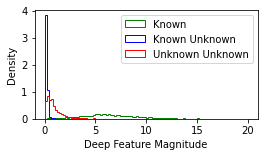

In [ ]:
# instantiate test set and according data loader
test_set = DataSet("test")
test_loader = torch.utils.data.DataLoader(test_set, 64, False)

# collect feature magnitudes for 
known, known_unknown, unknown = [], [], []

with torch.no_grad():
  # extract deep features magnitudes for validation set
  for x,t in validation_loader:
    # extract deep features (and logits)
    _, f = network(x.to(device))
    # compute norms
    norms = torch.linalg.norm(f, ord=2, dim=1)
    # split between known and unknown
    known_norm, known_norm_targets, unknown_norm = split_known_unknown(norms,t)
    # collect norms of known samples
    known.extend(known_norm.cpu().numpy())
    # collect norms of known unknwown samples
    known_unknown.extend(unknown_norm.cpu().numpy())

  for x,t in test_loader:
    # extract deep features (and logits)
    _, f = network(x.to(device))
    # compute norms
    norms = torch.linalg.norm(f, ord=2, dim=1)
    # split between known and unknown
    known_norm, known_norm_targets, unknown_norm = split_known_unknown(norms,t)
    # collect norms of known samples
          # no need to extra known again since they are identical in the validation set
    # collect norms of unknown unknown samples
    unknown.extend(unknown_norm.cpu().numpy())


# plot the norms as histograms
from matplotlib import pyplot
pyplot.figure(figsize=(4,2))

# keep the same maximum magnitude; I could also compute it, but I am too lazy.
max_mag = 20
# plot the three histograms
pyplot.hist(known, bins=100, range=(0,max_mag), density=True, color="g", histtype="step", label="Known")
pyplot.hist(known_unknown, bins=100, range=(0,max_mag), density=True, color="b", histtype="step", label="Known Unknown")
pyplot.hist(unknown, bins=100, range=(0,max_mag), density=True, color="r", histtype="step", label="Unknown Unknown")

# beautify plot
pyplot.legend()
pyplot.xlabel("Deep Feature Magnitude")
pyplot.ylabel("Density")

Task 10: Classification Evaluation
----------------------------------

For a fixed threshold of $\tau=0.98$, compute CCR and FPR for the test set.
A well-trained network can achieve a CCR of > 90% for an FPR < 10%.
You might need to vary the threshold.

<img src="https://s2.loli.net/2022/06/07/uY8riKwIP9TyLXA.png" width=30%/>

In [ ]:
tau = 0.98

# count the correctly classified and the total number of known samples
correct = known = 0
# count the incorrectly classified and the total number of unknown samples
false = unknown = 0

with torch.no_grad():
  for x,t in test_loader:
    # extract logits (and deep features)
    z, f = network(x.to(device))
    # compute softmax confidences
    softmax_confidences = torch.softmax(z, dim=1).cpu()
    # split between known and unknown
    known_sc, known_sc_targets, unknown_sc = split_known_unknown(softmax_confidences,t)
        # known_sc_targets --> [0,1,0,0]...
        # known_sc_targets.bool() -> [False,True,False,False]...
    # compute number of correctly classified knowns above threshold
    correct += torch.sum( torch.logical_and( 
        torch.argmax(known_sc,dim=1) == torch.argmax(known_sc_targets,dim=1),
        # known_sc[known_sc_targets.bool()] >= tau ### ??????
        (known_sc * known_sc_targets).sum(dim=1) >= tau ### 这样写也可以
        ))
    known += len(known_sc)

    # compute number of incorrectly accepted known samples
    false += torch.sum(torch.max(unknown_sc,dim=1)[0] > tau)
    unknown += len(unknown_sc)

# print both rates
print (f"CCR: {correct} of {known} = {correct/known*100:2.2f}%")
print (f"FPR: {false} of {unknown} = {false/unknown*100:2.2f}%")


CCR: 3501 of 3857 = 90.77%
FPR: 66 of 2093 = 3.15%
